In [66]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks

from tqdm.notebook import tqdm

import clip
import importlib

import json

In [75]:
importlib.reload(torchattacks.attack)
importlib.reload(torchattacks.attack_methods.fgsm)
importlib.reload(torchattacks.attack_methods.ffgsm)
importlib.reload(torchattacks.attack_methods.pgd)

<module 'torchattacks.attack_methods.pgd' from '/home/sazim/ICLR23/adv_attacks/code/torchattacks/attack_methods/pgd.py'>

### Define device type

In [2]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda" else {}
# print(kwargs)

# Additional Info when using cuda
if device.type == 'cuda':
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Number of GPU devices: 1
GPU device name: GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Load CLIP Model

In [3]:
def load_CLIP_pretrained_model(model_name):
    model, preprocess_transform = clip.load(model_name)
    return model, preprocess_transform

### Load MNIST data

In [4]:
def load_MNIST_data(train_batch_size, test_batch_size, preprocess, kwargs):
    mnist_transform = transforms.Compose([transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor()])

    mnist_train_data = TVdatasets.MNIST(root='../data/', 
                                        train=True,
                                        transform=preprocess,
                                        download=True)

    mnist_test_data = TVdatasets.MNIST(root='../data/',
                                      train=False,
                                      transform=preprocess,
                                      download=True)

    print("Number of train samples:", len(mnist_train_data))
    print("Number of test samples:", len(mnist_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=mnist_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=mnist_test_data,
                                            batch_size=test_batch_size,
                                            shuffle=True,
                                            **kwargs)
    
    return trainloader, testloader

### Show model overview details

In [5]:
def model_overview_desc(model):
    input_resolution = model.visual.input_resolution
    context_length = model.context_length
    vocab_size = model.vocab_size
    
    num_parameters = 0
    for p in model.parameters():
        num_parameters += np.prod(p.shape)

    print("Image input resolution:", input_resolution)
    print("Text desc context length:", context_length)
    print("Vocab size:", vocab_size)
    print("Number of model parameters:", int(num_parameters))

### Show sample images

In [6]:
def get_sample_imgs(dataloader, num_imgs=8):
#     sample_imgs = []
#     sample_labels = []

    for _, (batch_imgs, batch_labels) in enumerate(dataloader):
#         batch_imgs = batch_imgs.repeat(1, 3, 1, 1)
        for i in range(num_imgs):
            batch_imgs[i] = (batch_imgs[i] - batch_imgs[i].min()) / (batch_imgs[i].max() - batch_imgs[i].min())

        sample_imgs = batch_imgs[0:num_imgs]
        sample_gt_labels = batch_labels[0:num_imgs]
        
        break

#         test_sample_imgs.append(batch_imgs[i])
#         test_sample_labels.append(batch_labels[i])
    
    return sample_imgs, sample_gt_labels

In [7]:
def show_sample_imgs(imgs, classnames, gt_labels, model_pred):
    plt.figure(figsize=(14, 7))
    num_imgs = imgs.shape[0]
    
    if imgs.shape[1] == 3:
        imgs = np.transpose(imgs, (0,2,3,1))
    
    for i in range(num_imgs):
        plt.subplot(2, 4, i+1)
        plt.imshow(imgs[i])
        plt.title("GT: {}, Pred: {}".format(classnames[gt_labels[i]], classnames[model_pred[i]]))
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

### Text descriptions based on classnames (prompt engineering)

In [8]:
def get_text_descriptions(classnames, text_templates):
    text_descriptions = []

    for class_name in classnames:
        for template in text_templates:
            text_descriptions.append(template.format(class_name))

    return text_descriptions

### Predict zero-shot classification for MNIST sample images using CLIP

In [9]:
def construct_similarity_map(model, batch_imgs, text_desc=None, text_features=None):
    batch_imgs = batch_imgs.to(device)
#     print("Stacked images shape:", batch_imgs.shape)

    with torch.no_grad():
        img_features = model.encode_image(batch_imgs).float()
#         print("Encoded images shape:", img_features.shape)
    
    # each encoded image or text is a 512-dim feature vector in the embedding space
    # for each encoded image or text feature, divide by its length to make it a unit length vector
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)
    
    if text_features is None:
        text_tokens = clip.tokenize(text_desc).to(device)
#         print("Tokenized text shape:", text_tokens.shape)
        
        with torch.no_grad():
            text_features = model.encode_text(text_tokens).float()
            text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)
            
#     print("Encoded text shape:", text_features.shape)
    
    similarity_map = torch.matmul(img_features, text_features.T)
#     print("Cosine similarity map shape:", similarity_map.shape)
    
    return similarity_map

In [10]:
def plot_similarity_map(similarity_map, sample_imgs, text_desc):
    num_imgs = similarity_map.shape[1]
    num_texts = similarity_map.shape[0]

    plt.figure(figsize=(20, 12))
    plt.imshow(similarity_map, vmin=0.1, vmax=0.3)

    plt.yticks(range(num_texts), text_desc, fontsize=14)
    plt.xticks([])

    if sample_imgs.shape[1] == 3:
        sample_imgs = np.transpose(sample_imgs, (0,2,3,1))

    for idx, img in enumerate(sample_imgs):
#         img = np.transpose(img, (1,2,0))
        plt.imshow(img, extent=(idx - 0.5, idx + 0.5, -1.6, -0.6), origin="lower")

    for x in range(num_imgs):
        for y in range(num_texts):
            plt.text(x, y, f"{similarity_map[y, x]:.4f}", ha="center", va="center", size=10)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, num_texts - 0.5])
    plt.ylim([num_texts + 0.5, -2])

    plt.title("Cosine similarity map between text and image features", size=16)

### Computing standard clean ZS accuracy of CLIP on MNIST test data

In [11]:
def compute_test_accuracy(model, dataloader, text_desc=None, text_features=None, attack_obj=None):
    num_corr_pred = 0
    num_samples = 0
    model.eval()
    
    if text_features is None and text_desc is not None:
        text_tokens = clip.tokenize(text_desc).to(device)
        with torch.no_grad():
            text_features = model.encode_text(text_tokens).float()
            text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(dataloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
        
        if attack_obj is not None:
            batch_imgs = attack_obj(batch_imgs, batch_labels, text_features)

        similarity_map = construct_similarity_map(model, batch_imgs, text_features=text_features)
        batch_pred = torch.argmax(similarity_map, dim=1)

        num_corr_pred += float((batch_pred == batch_labels).sum())
        num_samples += batch_imgs.shape[0]

    test_accuracy = round(100.0 * num_corr_pred / num_samples, 4)
    
    return test_accuracy

## CLIP + MNIST

In [12]:
# print all available CLIP pretrained models and load one of the models
print("Available CLIP pretrained models:", clip.available_models())
model_CLIP, preprocess_CLIP = load_CLIP_pretrained_model("ViT-B/32")
print("\nImage Preprocessing Transform:\n", preprocess_CLIP)

# send model to device (cuda/cpu)
model_CLIP = model_CLIP.to(device)
model_CLIP.eval()

# describe model details
model_overview_desc(model_CLIP)

Available CLIP pretrained models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

Image Preprocessing Transform:
 Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fadb7633940>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Image input resolution: 224
Text desc context length: 77
Vocab size: 49408
Number of model parameters: 151277313


In [13]:
# load MNIST dataset
train_batch_size = 32
test_batch_size = 32
_, testloader = load_MNIST_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

# get MNIST text descriptions (classnames + text templates)
# mnist_classes = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
text_templates = ['a photo of digit {}']
mnist_text_desc = get_text_descriptions(mnist_classes, text_templates)

text_tokens = clip.tokenize(mnist_text_desc).to(device)
with torch.no_grad():
    mnist_text_features = model_CLIP.encode_text(text_tokens).float()
    mnist_text_features = mnist_text_features / torch.linalg.norm(mnist_text_features, dim=1, keepdim=True)

Number of train samples: 60000
Number of test samples: 10000


### Sample MNIST images

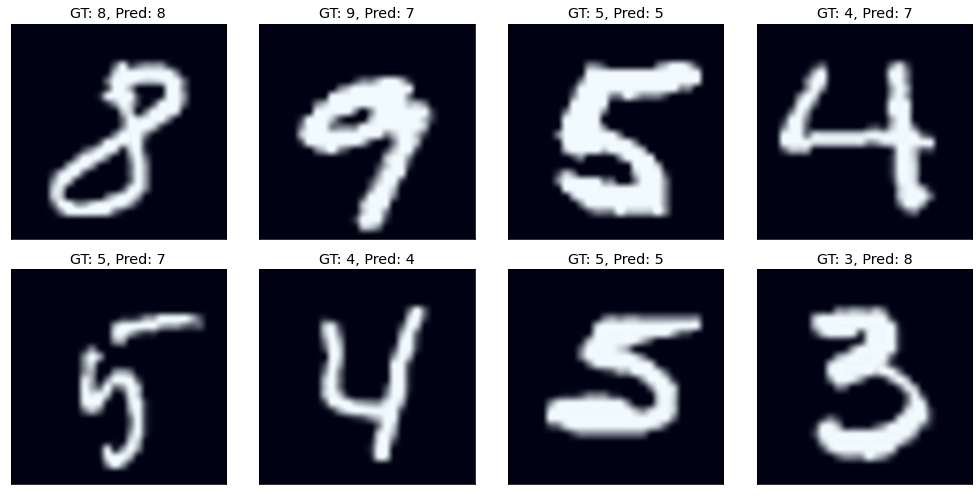

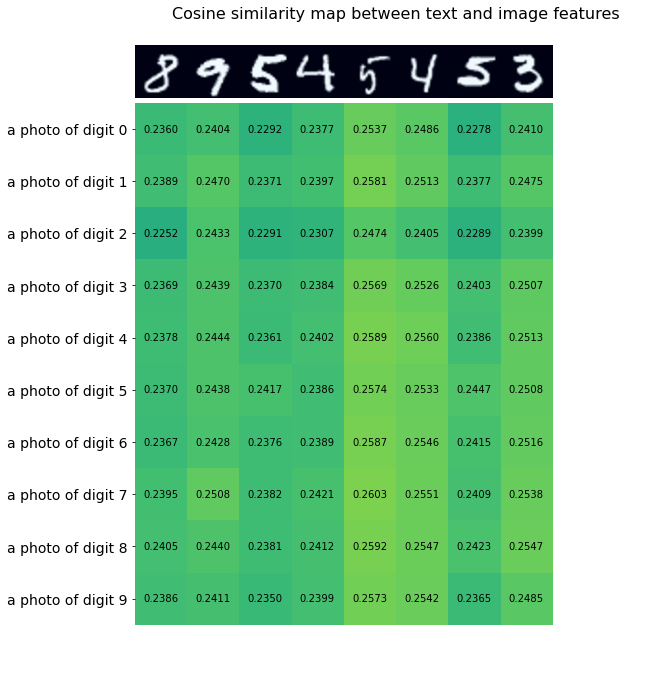

In [14]:
# show sample MNIST images
sample_imgs, sample_gt_labels = get_sample_imgs(testloader, num_imgs=8)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_imgs, text_features=mnist_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_imgs, mnist_classes, sample_gt_labels, sample_pred)

plot_similarity_map(sim_map.cpu().numpy().T, sample_imgs, mnist_text_desc)

### ZS-CLIP test accuracy on MNIST testset

In [15]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_features=mnist_text_features)
print("Standard clean ZS-CLIP accuracy on MNIST testset: {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean ZS-CLIP accuracy on MNIST testset: 22.46 %
Time taken: 16.73 s


### Sample MNIST adversarial images (FGSM)

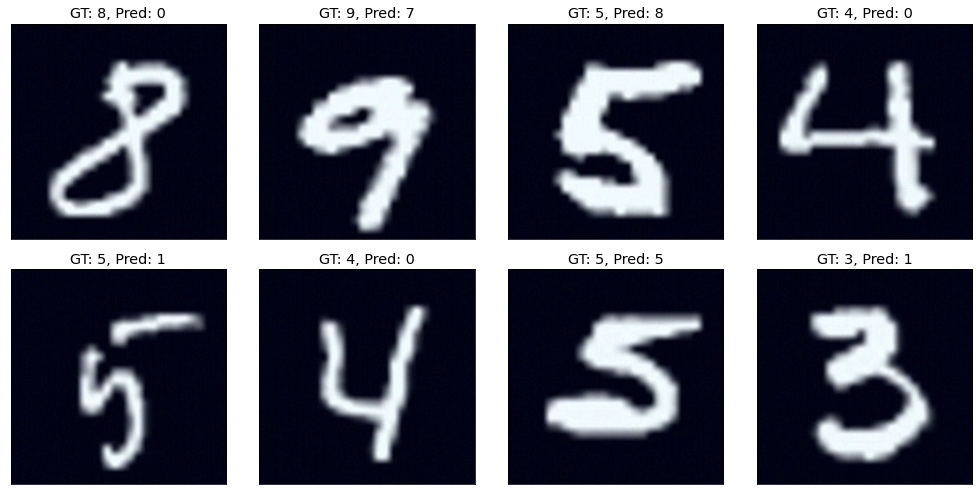

In [16]:
fgsm_attack = torchattacks.attack_methods.fgsm.FGSM_CLIP(model_CLIP, eps=2/255)

sample_adv_imgs = fgsm_attack(sample_imgs, sample_gt_labels, mnist_text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_features=mnist_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), mnist_classes, sample_gt_labels, sample_pred)

### ZS-CLIP test accuracy on FGSM attacked MNIST testset

In [26]:
# start_time = time.time()

# num_samples = 0
# num_corr_pred = 0
# model_CLIP.eval()

# for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = batch_imgs.to(device)
#     batch_labels = batch_labels.to(device)

#     X_test = fgsm_attack(batch_imgs, batch_labels, mnist_text_features)
#     Y_test_gt = batch_labels

#     # compute model prediction
#     similarity_map = construct_similarity_map(model_CLIP, X_test, text_features=mnist_text_features)
#     Y_test_pred = torch.argmax(similarity_map, dim=1)

#     num_samples += batch_imgs.shape[0]
#     num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

# test_acc = round(100.0 * num_corr_pred / num_samples, 4)

# print("Robust ZS-CLIP accuracy on MNIST testset (FGSM attack): {} %".format(test_acc))
# print("Time taken: {} s".format(round(time.time() - start_time, 2)))

In [17]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_features=mnist_text_features, attack_obj=fgsm_attack)
print("Robust ZS-CLIP accuracy on MNIST testset (FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on MNIST testset (FGSM attack): 18.01 %
Time taken: 21.21 s


## CLIP + CIFAR10

In [32]:
def load_CIFAR10_data(train_batch_size, test_batch_size, preprocess, kwargs):
    cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

    cifar10_train_data = TVdatasets.CIFAR10(root="../data/CIFAR10/", 
                                            train=True, 
                                            download=True, 
                                            transform=preprocess)

    cifar10_test_data = TVdatasets.CIFAR10(root="../data/CIFAR10/", 
                                           train=False, 
                                           download=True, 
                                           transform=preprocess)

    print("Number of train samples:", len(cifar10_train_data))
    print("Number of test samples:", len(cifar10_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=cifar10_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=cifar10_test_data,
                                             batch_size=test_batch_size,
                                             shuffle=True,
                                            **kwargs)

    return trainloader, testloader

### Load CIFAR10 data

In [29]:
# load CIFAR10 dataset
train_batch_size = 32
test_batch_size = 32
trainloader, testloader = load_CIFAR10_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

# get CIFAR10 text descriptions (classnames + text templates)
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
text_templates = ['a photo of a {}']
cifar10_text_desc = get_text_descriptions(cifar10_classes, text_templates)

text_tokens = clip.tokenize(cifar10_text_desc).to(device)
with torch.no_grad():
    cifar10_text_features = model_CLIP.encode_text(text_tokens).float()
    cifar10_text_features = cifar10_text_features / torch.linalg.norm(cifar10_text_features, dim=1, keepdim=True)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


### Sample CIFAR10 images

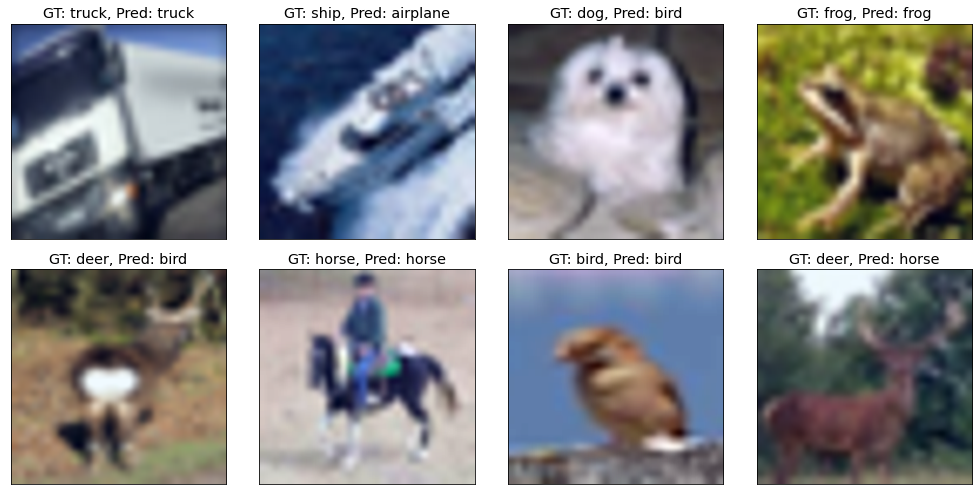

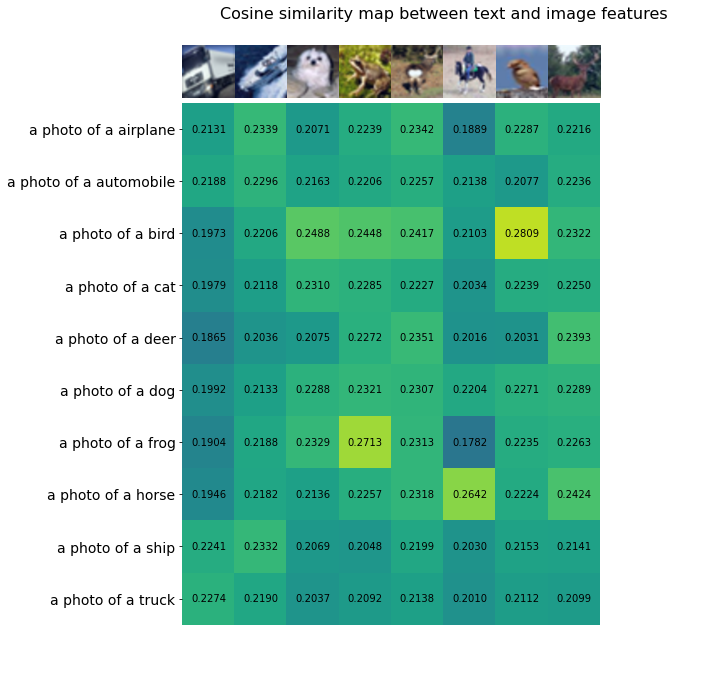

In [30]:
# show sample CIFAR10 images
sample_imgs, sample_gt_labels = get_sample_imgs(testloader, num_imgs=8)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_imgs, text_features=cifar10_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_imgs, cifar10_classes, sample_gt_labels, sample_pred)

plot_similarity_map(sim_map.cpu().numpy().T, sample_imgs, cifar10_text_desc)

### ZS-CLIP test accuracy on CIFAR10 testset

In [31]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_features=cifar10_text_features)
print("Standard clean ZS-CLIP accuracy on CIFAR10 testset: {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean ZS-CLIP accuracy on CIFAR10 testset: 88.77 %
Time taken: 18.81 s


### Sample CIFAR10 adversarial images (FGSM)

In [33]:
fgsm_attack = torchattacks.attack_methods.fgsm.FGSM_CLIP(model_CLIP, eps=2/255)

sample_adv_imgs = fgsm_attack(sample_imgs, sample_gt_labels, cifar10_text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_features=cifar10_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), cifar10_classes, sample_gt_labels, sample_pred)

### ZS-CLIP test accuracy on FGSM attacked CIFAR10 testset

In [36]:
# start_time = time.time()

# num_samples = 0
# num_corr_pred = 0
# model_CLIP.eval()

# # text_tokens = clip.tokenize(text_descriptions).to(device)
# # text_features = model_CLIP.encode_text(text_tokens).float()
# # text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

# for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = batch_imgs.to(device)
#     batch_labels = batch_labels.to(device)

#     X_test_adv = fgsm_attack(batch_imgs, batch_labels, cifar10_text_features)
#     Y_test_gt = batch_labels

#     # compute model prediction
#     img_features = model_CLIP.encode_image(X_test_adv).float()
#     img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

#     similarity_map = torch.matmul(img_features, cifar10_text_features.T)
#     Y_test_pred = torch.argmax(similarity_map, dim=1)

#     num_samples += batch_imgs.shape[0]
#     num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

# test_acc = round(100.0 * num_corr_pred / num_samples, 4)

# print("Robust ZS-CLIP accuracy on CIFAR10 testset (FGSM attack): {} %".format(test_acc))
# print("Time taken: {} s".format(round(time.time() - start_time, 2)))

In [37]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_features=cifar10_text_features, attack_obj=fgsm_attack)
print("Robust ZS-CLIP accuracy on CIFAR10 testset (FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on CIFAR10 testset (FGSM attack): 49.49 %
Time taken: 21.77 s


### Sample CIFAR10 adversarial images (Fast-FGSM)

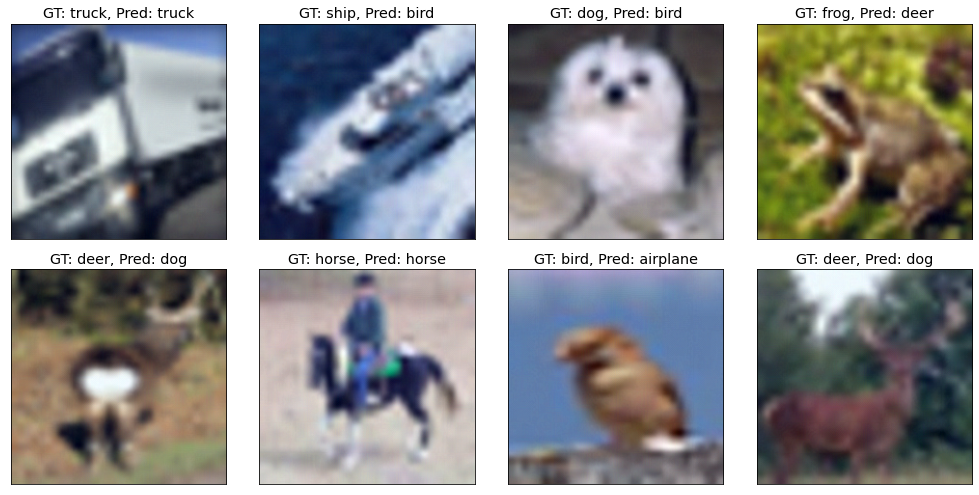

In [39]:
ffgsm_attack = torchattacks.attack_methods.ffgsm.FFGSM_CLIP(model_CLIP, eps=2/255, alpha=2/255)

# text_tokens = clip.tokenize(text_descriptions).to(device)
# text_features = model_CLIP.encode_text(text_tokens).float()
# text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

sample_adv_imgs = ffgsm_attack(sample_imgs, sample_gt_labels, cifar10_text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_features=cifar10_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), cifar10_classes, sample_gt_labels, sample_pred)

### ZS-CLIP accuracy on Fast-FGSM attacked CIFAR10 testset

In [45]:
# start_time = time.time()

# num_samples = 0
# num_corr_pred = 0
# model_CLIP.eval()

# # text_tokens = clip.tokenize(text_descriptions).to(device)
# # text_features = model_CLIP.encode_text(text_tokens).float()
# # text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

# for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = batch_imgs.to(device)
#     batch_labels = batch_labels.to(device)

#     X_test_adv = ffgsm_attack(batch_imgs, batch_labels, cifar10_text_features)
#     Y_test_gt = batch_labels

#     # compute model prediction
#     img_features = model_CLIP.encode_image(X_test_adv).float()
#     img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

#     similarity_map = torch.matmul(img_features, cifar10_text_features.T)
#     Y_test_pred = torch.argmax(similarity_map, dim=1)

#     num_samples += batch_imgs.shape[0]
#     num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

# test_acc = round(100.0 * num_corr_pred / num_samples, 4)

# print("Robust ZS-CLIP accuracy on CIFAR10 testset (Fast-FGSM attack): {} %".format(test_acc))
# print("Time taken: {} s".format(round(time.time() - start_time, 2)))

In [44]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_features=cifar10_text_features, attack_obj=ffgsm_attack)
print("Robust ZS-CLIP accuracy on CIFAR10 testset (Fast-FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on CIFAR10 testset (FGSM attack): 21.81 %
Time taken: 20.85 s


### Sample CIFAR10 adversarial images (PGD)

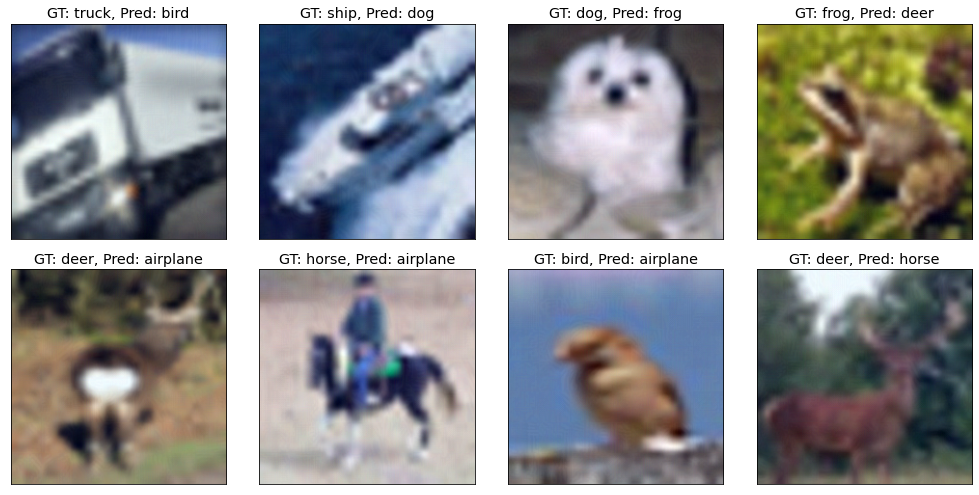

In [47]:
pgd_attack = torchattacks.attack_methods.pgd.PGD_CLIP(model_CLIP, eps=2/255, alpha=2/255, steps=20)

sample_adv_imgs = pgd_attack(sample_imgs, sample_gt_labels, cifar10_text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_features=cifar10_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), cifar10_classes, sample_gt_labels, sample_pred)

### ZS-CLIP accuracy on PGD attacked CIFAR10 testset

In [50]:
# start_time = time.time()

# num_samples = 0
# num_corr_pred = 0
# model_CLIP.eval()

# # text_tokens = clip.tokenize(text_descriptions).to(device)
# # text_features = model_CLIP.encode_text(text_tokens).float()
# # text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

# for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = batch_imgs.to(device)
#     batch_labels = batch_labels.to(device)

#     X_test_adv = pgd_attack(batch_imgs, batch_labels, cifar10_text_features)
#     Y_test_gt = batch_labels

#     # compute model prediction
#     img_features = model_CLIP.encode_image(X_test_adv).float()
#     img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

#     similarity_map = torch.matmul(img_features, cifar10_text_features.T)
#     Y_test_pred = torch.argmax(similarity_map, dim=1)

#     num_samples += batch_imgs.shape[0]
#     num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

# test_acc = round(100.0 * num_corr_pred / num_samples, 4)

# print("Robust ZS-CLIP accuracy on CIFAR10 testset (PGD attack): {} %".format(test_acc))
# print("Time taken: {} s".format(round(time.time() - start_time, 2)))

In [49]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, testloader, text_features=cifar10_text_features, attack_obj=pgd_attack)
print("Robust ZS-CLIP accuracy on CIFAR10 testset (PGD attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on CIFAR10 testset (PGD attack): 5.9 %
Time taken: 294.69 s


## CLIP + ImageNet

In [52]:
# !pip install git+https://github.com/modestyachts/ImageNetV2_pytorch

### Load ImageNet dataset

In [53]:
# from imagenetv2_pytorch import ImageNetV2Dataset

# images = ImageNetV2Dataset(transform=preprocess_CLIP)
# testloader = torch.utils.data.DataLoader(dataset=images, 
#                                          batch_size=32, 
#                                          shuffle=True,
#                                          **kwargs)
# print(len(testloader))

In [54]:
# imagenet_datapath = "/datasets/imagenet-ds/valid_64x64/"
# imagenet_datapath = "/datasets/Tiny-ImageNet/tiny-imagenet-200/"

In [55]:
def load_ImageNet_data(train_batch_size, test_batch_size, preprocess, kwargs):
    test_data = TVdatasets.ImageNet(root="../data/ImageNet/", 
                                    split='val', 
                                    transform=preprocess)
    
    print("Number of test samples:", len(test_data))

    testloader = torch.utils.data.DataLoader(dataset=test_data, 
                                             batch_size=test_batch_size, 
                                             shuffle=True, 
                                             **kwargs)

    return testloader

In [56]:
train_batch_size = 32
test_batch_size = 32

imagenet_testloader = load_ImageNet_data(train_batch_size, test_batch_size, preprocess_CLIP, kwargs)

Number of test samples: 50000


In [164]:
# imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]

In [69]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("../data/ImageNet/imagenet_class_index.json"))
imagenet_classes = [class_idx[str(k)][1] for k in range(len(class_idx))]

# get CIFAR10 text descriptions (classnames + text templates)
text_templates = ['a photo of a {}']
imagenet_text_desc = get_text_descriptions(imagenet_classes, text_templates)

text_tokens = clip.tokenize(imagenet_text_desc).to(device)
with torch.no_grad():
    imagenet_text_features = model_CLIP.encode_text(text_tokens).float()
    imagenet_text_features = imagenet_text_features / torch.linalg.norm(imagenet_text_features, dim=1, keepdim=True)

### Sample ImageNet images

In [72]:
# show sample CIFAR10 images
sample_imgs, sample_gt_labels = get_sample_imgs(imagenet_testloader, num_imgs=8)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_imgs, text_features=imagenet_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_imgs, imagenet_classes, sample_gt_labels, sample_pred)

# plot_similarity_map(sim_map.cpu().numpy().T, sample_imgs, imagenet_text_desc)

### ZS-CLIP test accuracy on ImageNet testset

In [75]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, imagenet_testloader, text_features=imagenet_text_features)
print("Standard clean ZS-CLIP accuracy on Imagenet testset: {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/1563 [00:00<?, ?it/s]

Standard clean ZS-CLIP accuracy on Imagenet testset: 56.78 %
Time taken: 533.79 s


### Sample ImageNet adversarial images (FGSM)

In [76]:
fgsm_attack = torchattacks.attack_methods.fgsm.FGSM_CLIP(model_CLIP, eps=2/255)

sample_adv_imgs = fgsm_attack(sample_imgs, sample_gt_labels, imagenet_text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_features=imagenet_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), imagenet_classes, sample_gt_labels, sample_pred)

### ZS-CLIP accuracy on FGSM attacked ImageNet testset

In [79]:
start_time = time.time()

num_samples = 0
num_corr_pred = 0
model_CLIP.eval()

# text_tokens = clip.tokenize(text_descriptions).to(device)
# text_features = model_CLIP.encode_text(text_tokens).float()
# text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(imagenet_testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test_adv = fgsm_attack(batch_imgs, batch_labels, imagenet_text_features)
    Y_test_gt = batch_labels

    # compute model prediction
    img_features = model_CLIP.encode_image(X_test_adv).float()
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, imagenet_text_features.T)
    Y_test_pred = torch.argmax(similarity_map, dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

test_acc = round(100.0 * num_corr_pred / num_samples, 4)

print("Robust ZS-CLIP accuracy on ImageNet testset (FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/1563 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on ImageNet testset (FGSM attack): 31.15 %
Time taken: 540.38 s


In [80]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, imagenet_testloader, text_features=imagenet_text_features, 
                                 attack_obj=fgsm_attack)
print("Robust ZS-CLIP accuracy on Imagenet testset (FGSM attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/1563 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on Imagenet testset (FGSM attack): 31.15 %
Time taken: 539.58 s


### Sample ImageNet adversarial images (PGD)

In [81]:
pgd_attack = torchattacks.attack_methods.pgd.PGD_CLIP(model_CLIP, eps=2/255, alpha=2/255, steps=20)

sample_adv_imgs = pgd_attack(sample_imgs, sample_gt_labels, imagenet_text_features)

# construct similarity map for (sample images, class descriptions)
sim_map = construct_similarity_map(model_CLIP, sample_adv_imgs, text_features=imagenet_text_features)

# predict CLIP model output on sample images
sample_pred = torch.argmax(sim_map, dim=1)

show_sample_imgs(sample_adv_imgs.cpu().numpy(), imagenet_classes, sample_gt_labels, sample_pred)

### ZS-CLIP test accuracy on PGD attacked ImageNet testset

In [82]:
start_time = time.time()

num_samples = 0
num_corr_pred = 0
model_CLIP.eval()

# text_tokens = clip.tokenize(text_descriptions).to(device)
# text_features = model_CLIP.encode_text(text_tokens).float()
# text_features = text_features / torch.linalg.norm(text_features, dim=1, keepdim=True)

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(imagenet_testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test_adv = pgd_attack(batch_imgs, batch_labels, imagenet_text_features)
    Y_test_gt = batch_labels

    # compute model prediction
    img_features = model_CLIP.encode_image(X_test_adv).float()
    img_features = img_features / torch.linalg.norm(img_features, dim=1, keepdim=True)

    similarity_map = torch.matmul(img_features, imagenet_text_features.T)
    Y_test_pred = torch.argmax(similarity_map, dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += float((Y_test_pred == Y_test_gt).sum())

test_acc = round(100.0 * num_corr_pred / num_samples, 4)

print("Robust ZS-CLIP accuracy on ImageNet testset (PGD attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/1563 [00:00<?, ?it/s]

Robust ZS-CLIP accuracy on ImageNet testset (PGD attack): 15.274 %
Time taken: 1479.93 s


In [ ]:
start_time = time.time()
test_acc = compute_test_accuracy(model_CLIP, imagenet_testloader, text_features=imagenet_text_features, 
                                 attack_obj=pgd_attack)
print("Robust ZS-CLIP accuracy on Imagenet testset (PGD attack): {} %".format(test_acc))
print("Time taken: {} s".format(round(time.time() - start_time, 2)))

  0%|          | 0/1563 [00:00<?, ?it/s]